# Multiple Scatterers Position Detection Experiment Setup

This notebook is used to verify and prepare the experimental setup for testing position detection performance with multiple scatterers. The goal is to evaluate how different electromagnetic imaging algorithms perform when trying to locate multiple objects with different geometries and permittivities.

## Experiment Overview
- **Test Problem**: Multiple scatterers with different shapes (star, rhombus, cross)
- **Primary Focus**: Position error evaluation ($\zeta_P$ indicator)
- **Secondary Focus**: Shape error evaluation ($\zeta_S$ indicator)
- **Scenario**: Strong scatterers where traditional methods struggle with geometry recovery

## Problem Configuration

Setting up the experimental parameters and creating the test scenario with multiple scatterers:

### Key Parameters:
- **Domain size**: 2λ × 2λ (square imaging domain)
- **Resolution**: 200×200 pixels for high-fidelity ground truth
- **Noise level**: 5% additive noise to simulate realistic measurements
- **Number of sources/measurements**: 80 each (circular array configuration)
- **Observation radius**: 4λ from the imaging domain center

### Multiple Scatterers:
1. **5-pointed Star**: ε_r = 5.0, centered at (0.4λ, -0.4λ), rotated 30°
2. **Rhombus**: ε_r = 4.0, centered at (0.7λ, 0.1λ), rotated 60°
3. **Cross**: ε_r = 3.5, centered at (0.2λ, 0.6λ), no rotation

This configuration creates a challenging scenario with overlapping scattering patterns from different geometries.

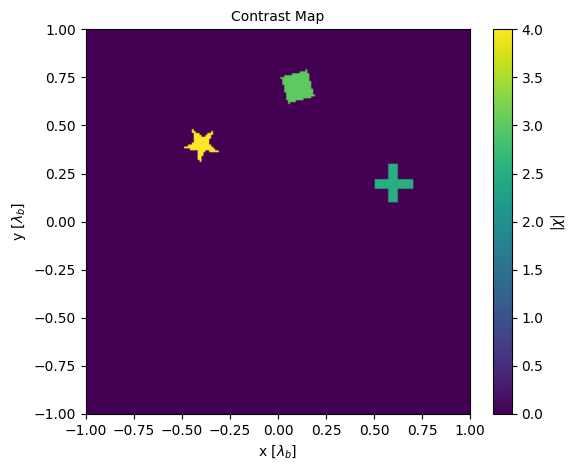

In [ ]:
import sys
sys.path.insert(1, '../../../eispy2d/library/')

import configuration as cfg
import inputdata as ipt
import result as rst
import draw
import mom_cg_fft as mom

# Parameters
name = 'multiple'
NM = NS = 80
Ro = 4.
lambda_b = 1.
epsilon_rb = 1.
Lx = Ly = 2.
E0 = 1.
perfect_dielectric = True
resolution = (200, 200)
noise = 5.
indicators = [rst.SHAPE_ERROR, rst.POSITION_ERROR]
epsilon_rd = [5., 4., 3.5]
l = 0.1
position = [.4, -.4]
rotate = 30

config = cfg.Configuration(name=name + '.cfg', number_measurements=NM, 
                           number_sources=NS, observation_radius=Ro, 
                           wavelength=lambda_b,
                           background_permittivity=epsilon_rb,
                           image_size=[Ly, Lx], magnitude=E0,
                           perfect_dielectric=perfect_dielectric)


test = ipt.InputData(name=name + '.ipt', configuration=config, 
                     resolution=resolution, noise=noise, indicators=indicators)

test.rel_permittivity, _ = draw.star5(
    l, axis_length_x=Lx, axis_length_y=Ly, resolution=resolution,
    background_rel_permittivity=epsilon_rb, object_rel_permittivity=epsilon_rd[0],
    center=position, rotate=30.
)

test.rel_permittivity, _ = draw.rhombus(
    l, l, axis_length_x=Lx, axis_length_y=Ly, center=[.7, .1],
    background_rel_permittivity=epsilon_rb, object_rel_permittivity=epsilon_rd[1],
    rotate=60, rel_permittivity=test.rel_permittivity
)

test.rel_permittivity, _ = draw.cross(
    2*l, 2*l, l/2, axis_length_x=Lx, axis_length_y=Ly,
    object_rel_permittivity=epsilon_rd[2], center=[.2, 0.6], rotate=0.,
    rel_permittivity=test.rel_permittivity
)

forward = mom.MoM_CG_FFT(tolerance=1e-3, maximum_iterations=10_000,
                         parallelization=True)

_ = forward.solve(test)

# print(test)
test.draw(show=True)

## Algorithm Performance Evaluation

Now we test different electromagnetic imaging algorithms to evaluate their performance on this multiple scatterer scenario. The goal is to understand which methods can best handle the challenging task of position detection when multiple objects with different properties are present.

### 1. First-Order Born Approximation (FOBA)

Testing the linearized Born approximation with Tikhonov regularization:
- **Method**: First-Order Born Approximation
- **Regularization**: Tikhonov with fixed parameter (λ = 1e-1)
- **Discretization**: Richmond method with 40×40 resolution
- **Expected behavior**: Should work reasonably well for weak scatterers but may struggle with strong contrast objects

Method: First-Order Born Approximation
Alias: ba
Input Data: multiple.ipt
Discretization: Richmond Method (40x40)
Parallelization: False
Method of Moments - CG-FFT (iterations=5000, tolerance=1.0e-03)
Regularization Method: Tikhonov
Choice strategy: fixed
Parameter value: 1.000e-01


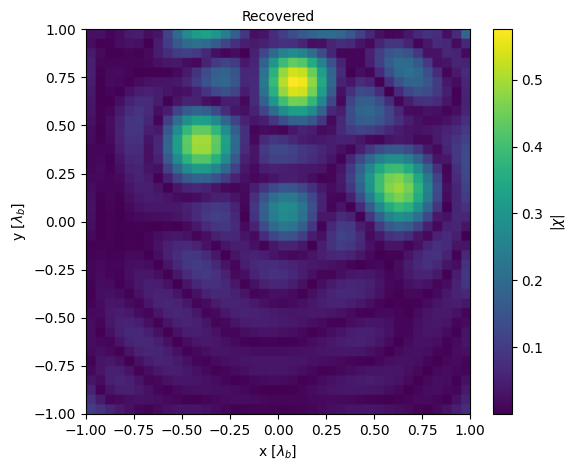

In [25]:
import richmond as ric
import bornapprox as ba
import regularization as reg

resolution = (40, 40)
discretization = ric.Richmond(configuration=config,
                              elements=resolution)

regularization = reg.Tikhonov(reg.TIK_FIXED, parameter=1e-1)
method = ba.FirstOrderBornApproximation(regularization)
result = method.solve(test, discretization)
result.plot_map(show=True)

### 2. Subspace-Based Optimization Method (SOM)

Testing the SOM algorithm, which uses eigenvalue decomposition and optimization:
- **Method**: Subspace-Based Optimization Method
- **Stop criteria**: Maximum 30 iterations
- **Expected behavior**: Should provide better reconstruction for strong scatterers compared to Born approximation
- **Advantages**: Less sensitive to multiple scattering effects

Method: Subspace-based Optimization Method
Alias: som
Input Data: multiple.ipt
Discretization: Richmond Method (40x40)
Method of Moments - CG-FFT (iterations=5000, tolerance=1.0e-03)
Stop Criteria
Maximum number of iterations: 30
Iteration: 1 -  Shape: 146.61, Position: 4.74,
Iteration: 2 -  Shape: 154.28, Position: 4.53,
Iteration: 3 -  Shape: 150.44, Position: 5.08,
Iteration: 4 -  Shape: 146.61, Position: 5.53,
Iteration: 5 -  Shape: 142.77, Position: 5.33,
Iteration: 6 -  Shape: 142.77, Position: 5.33,
Iteration: 7 -  Shape: 142.77, Position: 5.33,
Iteration: 8 -  Shape: 147.05, Position: 6.21,
Iteration: 9 -  Shape: 147.05, Position: 6.21,
Iteration: 10 -  Shape: 147.49, Position: 6.84,
Iteration: 20 -  Shape: 140.71, Position: 7.55,
Iteration: 30 -  Shape: 137.32, Position: 8.38,


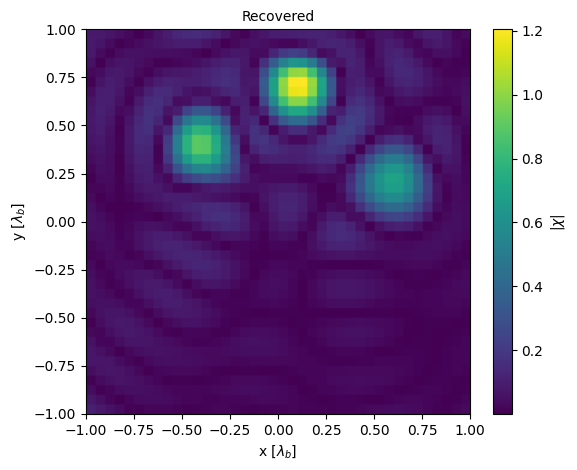

In [26]:
import som
import stopcriteria as stp

method = som.SubspaceBasedOptimizationMethod(stp.StopCriteria(max_iterations=30))
result = method.solve(test, discretization)
result.plot_map(show=True)

### 3. Orthogonality Sampling Method (OSM)

Testing the OSM algorithm, which is particularly effective for qualitative imaging:
- **Method**: Orthogonality Sampling Method  
- **Threshold**: 0.35 (controls sensitivity for object detection)
- **Expected behavior**: Excellent for shape and position detection, especially good at handling multiple scatterers
- **Advantages**: Robust to noise, good spatial resolution for position detection

Method: Orthogonality Sampling Method
Alias: osm
Input Data: multiple.ipt
Discretization: Richmond Method (40x40)
Threshold: 0.35


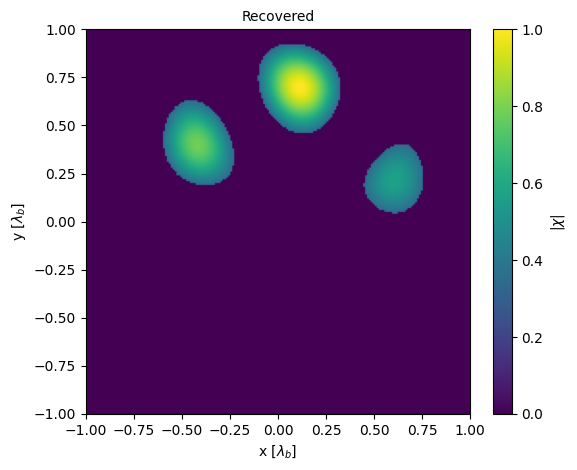

In [27]:
import osm

method = osm.OrthogonalitySamplingMethod(threshold=.35)
result = method.solve(test, discretization)
result.plot_map(show=True)

### Experimental Validation:
The results are as expected.